In [ ]:
%matplotlib inline

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
colors = [
    "#0000FF",  # Blue
    "#3333FF",  # Intermediate blue
    "#6666FF",  # Light blue
    "#9999FF",  # Very light blue
    "#CCCCFF",  # Pale blue
    "#FFCCCC",  # Pale red
    "#FF9999",  # Light red
    "#FF6666",  # Red-orange
    "#FF3333"   # Red
]
plt.style.use("ggplot")

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250$\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [ ]:
#!wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat

In [74]:
# Basic class & functions
from typing import Any
import scipy.integrate as integrate
band_215 = np.loadtxt('./data/BICEP_BICEP2.150GHz.dat')
band_222 = np.loadtxt('./data/BICEP_BICEP2.220GHz.dat')
band_295 = np.loadtxt('./data/BICEP_BICEP2.95GHz.dat')

bands = ['u', 'g', 'r', 'i', 'z', 'y']
filters = []
for i, band in enumerate(bands):
    file = pd.read_csv('./data/LSST_LSST.' + band + '_filter.dat', delimiter=' ')
    filt = np.array(file.values)
    filters.append(filt/1e4)
lam_eff = [0.3671, 0.4827, 0.6223, 0.7546, 0.8691, 0.9712]

data = np.loadtxt('aless_average_seds.dat')[:,:2]
def AB_func(wavelength):
    F_nu = 3.631e-3  # Flux in Jy (3631 Jy in erg/s/cm^2/Hz)
    c = 2.998e14  # Speed of light in Å/s
    F_ab = np.zeros([len(wavelength), 2])
    F_ab[:,0] = wavelength
    F_ab[:,1] = F_nu 
    return F_ab

c = 2.9979e14 # in \mu m/s
def redden_SED(sed, redshift):
    sed_z = np.zeros(sed.shape)
    sed_z[:,0] = sed[:,0]*(1+redshift) # wavelength, multiply by (1+z)
    sed_z[:,1] = sed[:,1]*(1e-5/cosmo.luminosity_distance(redshift).value)**2*(1+redshift)
    return sed_z

def flux_wave(sed, band):
    sed_int = np.interp(band[:,0], sed[:,0], sed[:,1])
    #plt.loglog(band[:,0], sed_int)
    #plt.show()
    freq = c/band[:,0]
    norm_flux =  integrate.simps(freq**2/c*sed_int*band[:,1]*band[:,0], band[:,0])
    norm = integrate.simps(band[:,1]*band[:,0], band[:,0])
    return norm_flux/norm # In W/m^2

class k_correct():
    
    def __init__(self,sed, ref):
        self.sed = sed
        self.ref = ref
    
    
    def __call__(self, band_index, z):
        band = filters[band_index]
        if band[:,0].max()/(1+z)<filters[0][:,0].min():
            return np.nan
        band_q = self._search_band(band_index, z)
        
        return self._between_bands(band, band_q, z)
    
    def _search_band(self, band_index, z):
        lam_eff_e = lam_eff[band_index]/(1+z)
        filt_index = np.argmin(np.abs(lam_eff_e-lam_eff))
        return filters[filt_index]
    
    def _between_bands(self, band_1, band_2, z):
        sed_z = redden_SED(self.sed, z)
        sed_ = np.zeros(sed_z.shape)
        #sed_[:,0] = sed_z[:,0]/(1+z)
        #sed_[:,1] = sed_z[:,1]
        
        f_s1 = flux_wave(sed_z, band_1)
        f_r1 = flux_wave(self.ref, band_1)
        sed_z[:,0]/=(1+z)
        f_s2 = flux_wave(sed_z, band_2)
        f_r2 = flux_wave(self.ref, band_2)
        
        #print(f_s1, f_r1, f_s2, f_r2)
        
        return -2.5*np.log10(f_s1/f_s2*(f_r2/f_r1)/(1+z))


C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\2255449202.py:35: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_flux =  integrate.simps(freq**2/c*sed_int*band[:,1]*band[:,0], band[:,0])
C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\2255449202.py:36: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm = integrate.simps(band[:,1]*band[:,0], band[:,0])


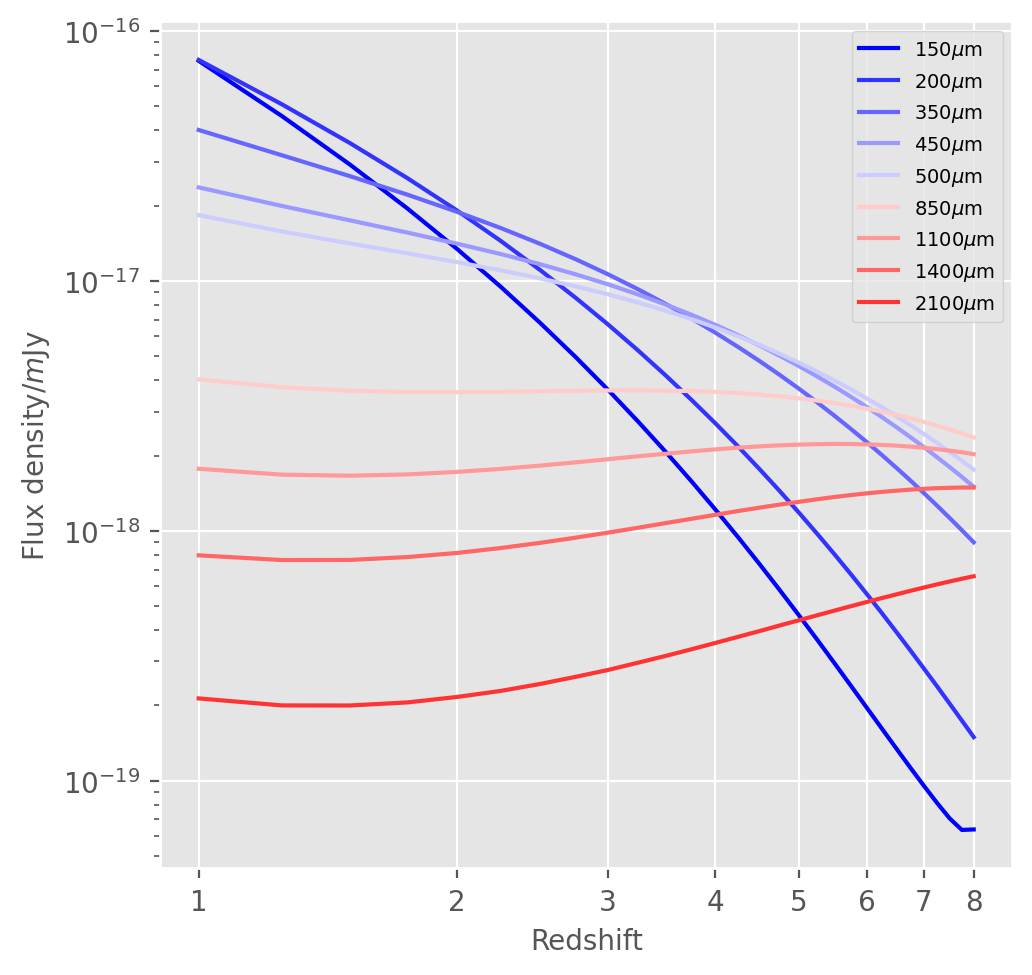

In [32]:
# 1.1

band_centers = np.array([150, 200, 350, 450, 500, 850, 1100, 1400, 2100])

redshifts = np.linspace(1,8,29)
flux_dst = np.zeros([12,len(redshifts)])
plt.figure(figsize=(5.5,5.5), dpi = 200)
for i in range(0,9):
    band = np.ones([10000,2])
    band[:,0] = np.linspace(band_centers[i]-1.5, band_centers[i]+1.5, 10000)
    for i_z, z in enumerate(redshifts):
        sed_ = redden_SED(data, z)
        flux = flux_wave(sed_, band)
        flux_dst[i, i_z] = flux*band_centers[i]**2/c
    plt.plot(redshifts, flux_dst[i], label = str(band_centers[i])+'$\\mu$m', color = colors[i])
plt.legend(fontsize = 7, loc = 'upper right')
plt.xlabel('Redshift', fontsize = 10)
plt.ylabel('Flux density/$m$Jy', fontsize = 10)
plt.xscale('log')
plt.yscale('log')
plt.xticks(np.linspace(1,8,8),[str(j) for j in range(1,9)])
plt.show()

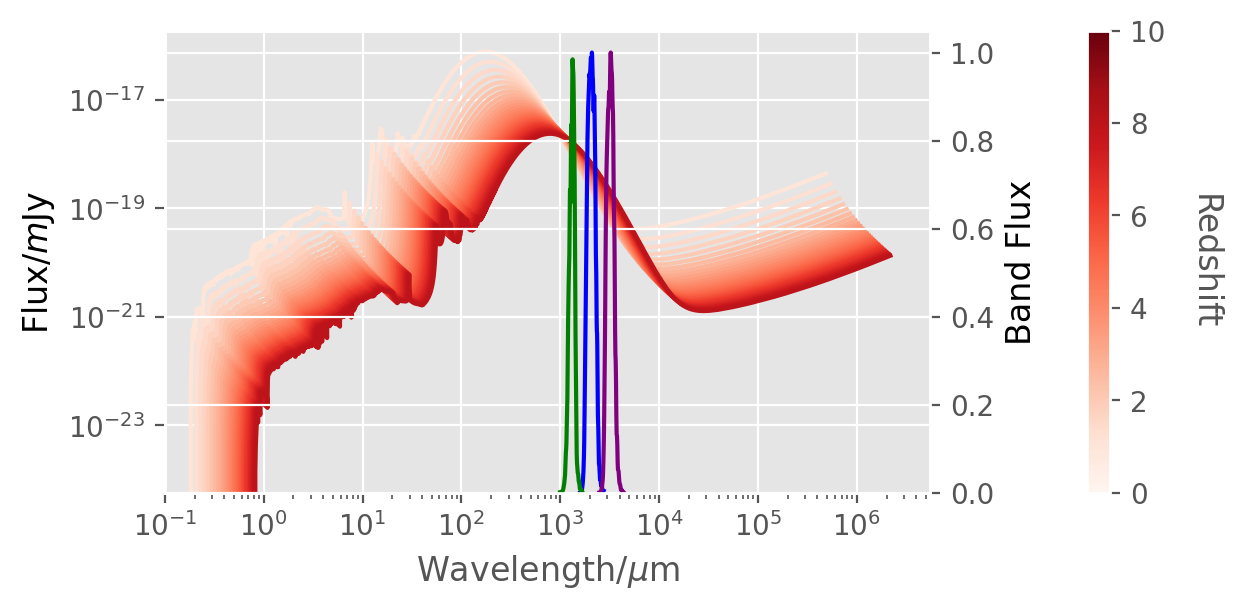

In [17]:
# 1.2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Sample redshift data

# Sample redshift data
redshifts = np.linspace(1, 8, 29)

norm = Normalize(vmin=0, vmax=10)
cmap = plt.get_cmap('Reds')
fig, ax1 = plt.subplots(figsize=(7, 3), dpi=200)

# Plot the SEDs with colors based on redshift
for i_z, z in enumerate(redshifts):
    sed_ = redden_SED(data, z)  # Assuming this function already works as intended
    color = cmap(norm(z))  # Map z to the color map
    ax1.plot(sed_[:, 0], sed_[:, 1], color=color, label=f'z={z:.2f}')

# Configure the main (left) axis
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Wavelength/$\\mu$m')
ax1.set_ylabel('Flux/$m$Jy', color='black')
#ax1.set_ylim(1e-5)
ax1.set_xlim(0.1)

# Create a secondary axis on the right
ax2 = ax1.twinx()
# Plot the bands on the secondary y-axis
ax2.plot(band_215[:, 0]/10**4, band_215[:, 1], label='Band 215', color='blue')
ax2.plot(band_222[:, 0]/10**4, band_222[:, 1], label='Band 222', color='green')
ax2.plot(band_295[:, 0]/10**4, band_295[:, 1], label='Band 295', color='purple')

# Configure the secondary (right) axis
ax2.set_ylim(0)
ax2.set_ylabel('Band Flux', color='black')

# Add a colorbar for the redshift values
#sm = ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])  # Needed for ScalarMappable to work properly
cbar = fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), ax=[ax1, ax2], pad=0.01)
cbar.set_label('Redshift', rotation=270, labelpad=20)

#plt.tight_layout()
plt.show()


C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\3064436111.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  sed_z[:,1] = sed[:,1]*(1e-5/cosmo.luminosity_distance(redshift).value)**2*(1+redshift)
C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\3064436111.py:29: RuntimeWarning: invalid value encountered in multiply
  sed_z[:,1] = sed[:,1]*(1e-5/cosmo.luminosity_distance(redshift).value)**2*(1+redshift)
C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\3064436111.py:37: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm_flux =  integrate.simps(freq**2/c*sed_int*band[:,1]*band[:,0], band[:,0])
C:\Users\liwen\AppData\Local\Temp\ipykernel_39988\3064436111.py:38: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  norm = integrate.simps(band[:,1]*band[:,0], band[:,0])
C:\Users\liwen\AppData\Local\Tem

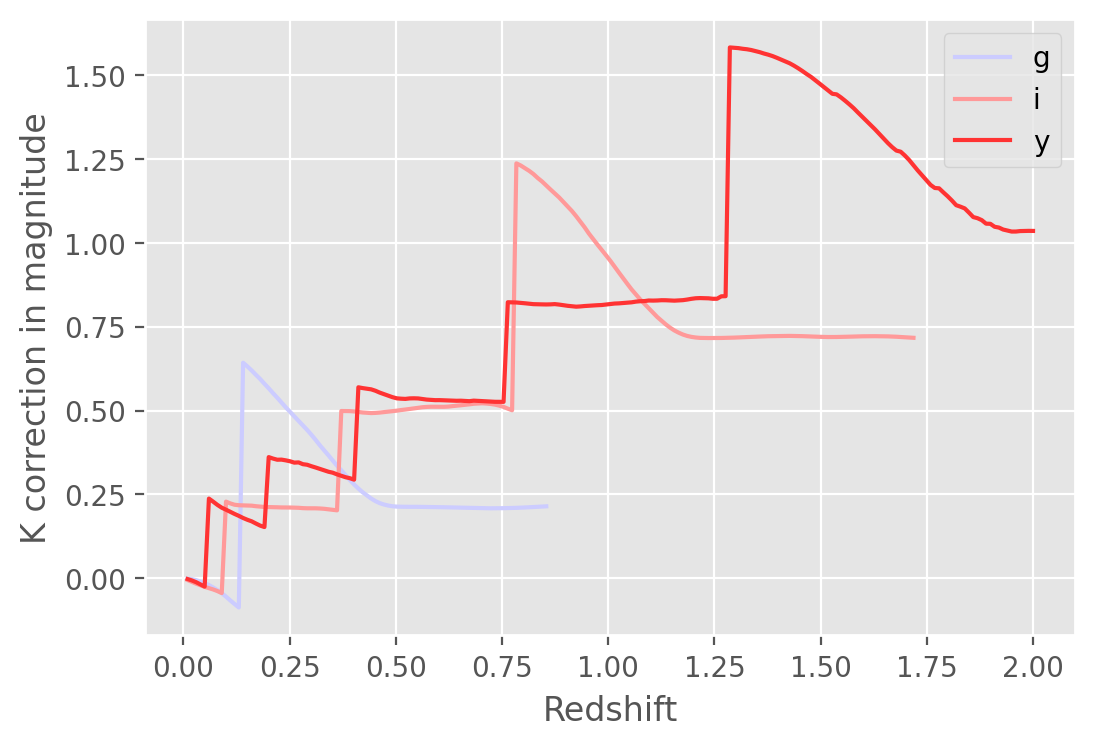

In [77]:
# 1.3
test = k_correct(data, AB_func(data[:,0]))
z_s = np.linspace(0,2,200)
plt.figure(figsize=(6,4), dpi = 200)
for i in [1,3,5]:
    k_c = []
    for (j,z) in enumerate(z_s):
        k_c.append(test(i, z))
    plt.plot(z_s, k_c, label = bands[i], color = colors[i+3])
plt.xlabel('Redshift')
plt.ylabel('K correction in magnitude')
plt.legend()
plt.show()

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

In [2]:
from scipy.optimize import fsolve
cosmo_SN = FlatLambdaCDM(H0 = 72, Om0 = 0.3)
def _M2m(M, d):
    m = M+5*np.log10(d)+25
    return m

def _m2d(m):
    lum_d = 10**((m+19)/5)/1e5
    '''z = []
    for d in lum_d:
        def eq(z):
                return cosmo_SN.luminosity_distance(z).value-d
        z.append(fsolve(eq, 0)[0])
    z = np.array(z)
    prop_d = cosmo_SN.comoving_distance(z).value/(1+z)'''
    return lum_d#, prop_d




class SNs():
    H_0 = 72 # km/s/Mpc
    d_max = 2500 # Mpc
    v_s = 600 # km/s
    
    def __init__(self):
        pass

    def __call__(self, n_star): # generate SNs
        points = []
        self.n_star = n_star
        for _ in range(n_star):
            while True:
                # Generate a random point inside a cube of side length 2*radius
                point = np.random.uniform(-self.d_max, self.d_max, 6)
                point[3] = np.linalg.norm(point[:3])
                point[4] = np.random.randn()*self.v_s+self.H_0*point[3]
                point[5] = np.random.randn()-19
                #point[6] = self._d2z(point[3])
                # Check if the point lies inside the sphere
                if  point[3] <= self.d_max:
                    points.append(point)
                    break
        self.stars = np.array(points)
        return np.array(points)
    
    def _d2z(self, d):
        def eq(z):
            return cosmo_SN.comoving_distance(z).value/(1+z)-d
        z_value = fsolve(eq, 0)[0]
        return z_value


Monte Carlo mean distance: 1943.856398395405Mpc
Theoretical mean distance:  = 0.75*2500 = 1875.0Mpc
Average magnitude for all samples = 22.380639249361042
Average magnitude for detected samples = 19.688945921504587


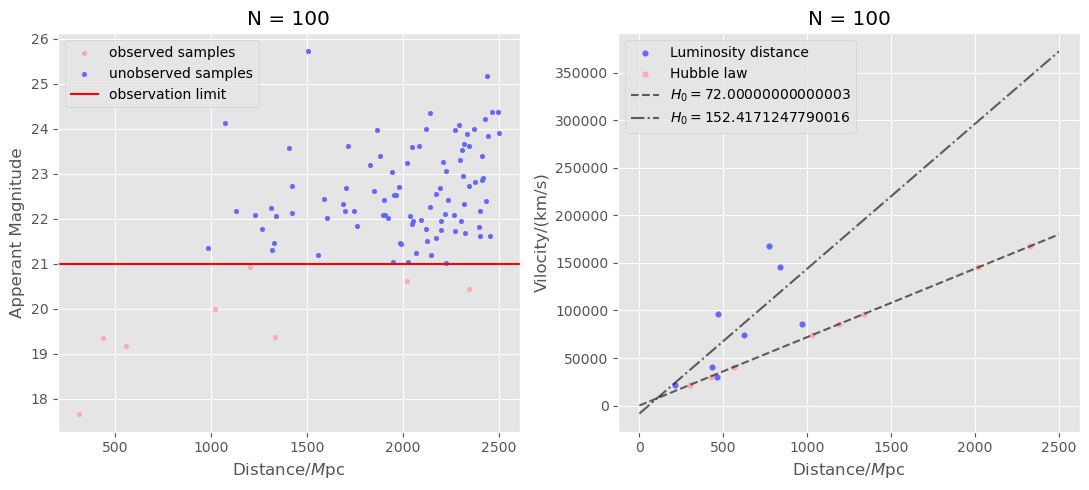

Monte Carlo mean distance: 1863.9235692001487Mpc
Theoretical mean distance:  = 0.75*2500 = 1875.0Mpc
Average magnitude for all samples = 22.246307693773204
Average magnitude for detected samples = 20.177776191235413


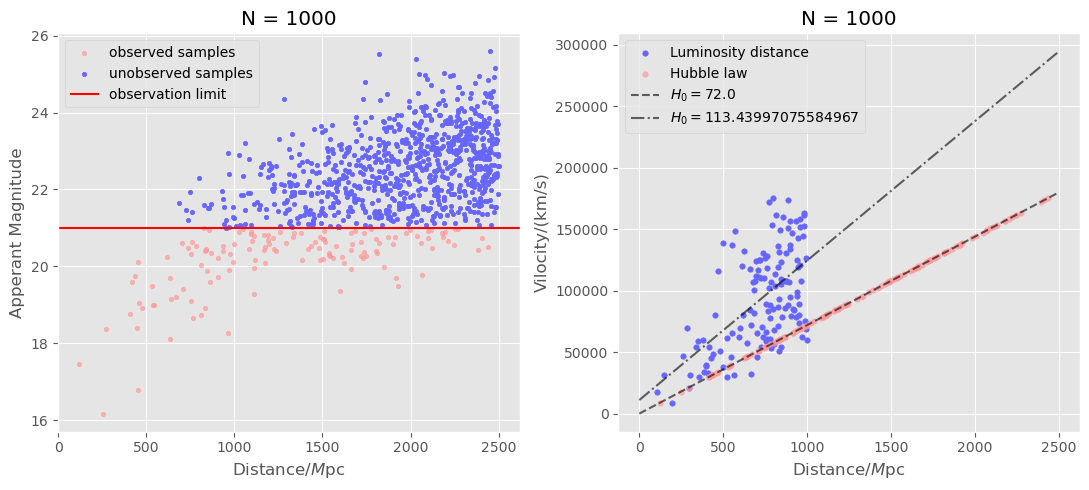

Monte Carlo mean distance: 1868.8102643301054Mpc
Theoretical mean distance:  = 0.75*2500 = 1875.0Mpc
Average magnitude for all samples = 22.25879758019691
Average magnitude for detected samples = 20.21379958761868


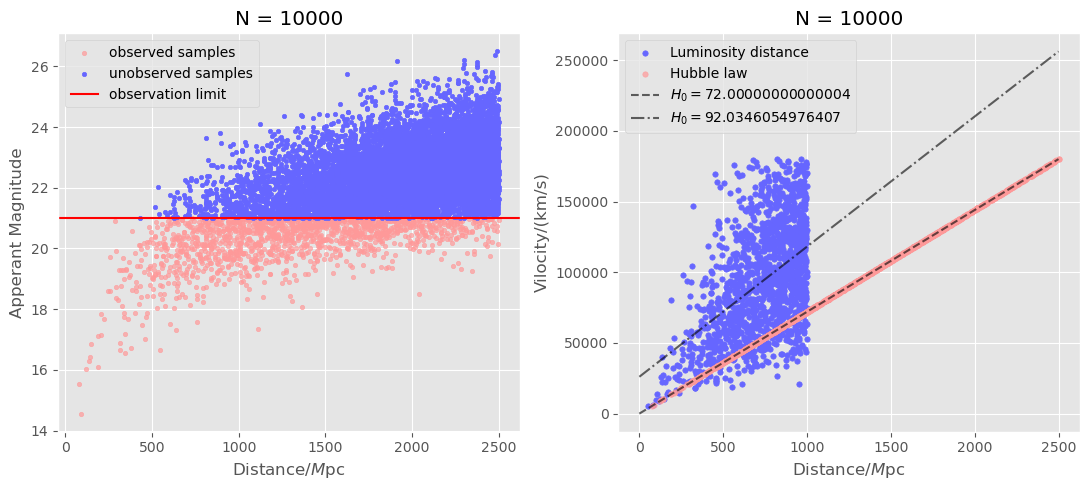

In [20]:
def make_plots(n_sam):
    sample = SNs()
    sample(n_sam)
    m = _M2m(sample.stars[:,5], sample.stars[:,3])
    threshold = 21
    lum_d = _m2d(m)

    mean_distance = sample.stars[:,3].mean()
    h_l, b_l = np.polyfit(lum_d[m<threshold], sample.stars[m<threshold,4], 1)
    h_0, b_0 = np.polyfit(sample.stars[m<threshold,4]/sample.H_0, sample.stars[m<threshold,4], 1)

    print('Monte Carlo mean distance: '+str(mean_distance)+'Mpc')
    print('Theoretical mean distance: '+' = 0.75*2500 = '+str(3/4*2500)+'Mpc') 
    print('Average magnitude for all samples = '+str(m[:].mean()))
    print('Average magnitude for detected samples = '+str(m[m<threshold].mean()))
    

    plt.figure(figsize=(11,5))
    plt.subplot(121)
    plt.scatter(sample.stars[m<threshold,3], m[m<threshold], s = 10, color = "#FF9999", label = 'observed samples', alpha = 0.7)
    plt.scatter(sample.stars[m>threshold,3], m[m>threshold], s = 10, color = "#6666FF", label = 'unobserved samples')
    plt.axhline(threshold, c = 'red', label = 'observation limit')
    plt.title('N = '+str(n_sam))
    plt.legend()
    plt.xlabel('Distance/$M$pc')
    plt.ylabel('Apperant Magnitude')


    plt.subplot(122)
    d = np.linspace(0,2500, 100)
    plt.title('N = '+str(n_sam))
    plt.scatter(lum_d[m<threshold], sample.stars[m<threshold,4], s = 15, color = "#6666FF", label = 'Luminosity distance')
    plt.scatter(sample.stars[m<threshold,4]/sample.H_0, sample.stars[m<threshold,4], s = 15, color = "#FF9999", alpha=0.7, label = 'Hubble law')
    plt.plot(d, d*h_0+b_0,
            label = '$H_0 = $'+str(h_0), linestyle = '--', color = 'black', alpha = 0.6,
            )
    plt.plot(d, d*h_l+b_l,
            label = '$H_0 = $'+str(h_l), linestyle = '-.', color = 'black', alpha = 0.6,
            )
    #plt.xlim(0,1050)
    #plt.ylim(0,71000)
    plt.legend()
    plt.xlabel('Distance/$M$pc')
    plt.ylabel('Vilocity/(km/s)')


    plt.tight_layout()
    plt.show()

for n_sam in [100,1000,10000]:
    make_plots(n_sam)

# Answer for Q2 

3. Observing limit would make the luminocity distance for all our observed samples below 1000 Mpc. However, due to velocity dispersion and the under certainty in absolute magenitude, we could see quite some samples with actual distance larger than 1000 Mpc. So, the observing limit would cause a systematic underestimate for the luminocity distance.

4. We would have a bias for about ~0.2 level magnitude. The impact of peculiar velocity is rather small, as the stars has a mean distance of ~ 1875 Mpc adn the velocity from Hubble's law would be $10^4$ km/s. 
Basically, Malmquist bias would make the apperant magnitude go below a certain threshold, thus induce a threshold in the luminocity distance. However, as our absolute magnitude has a intrinsic dispersion of 1 magnitude, the threshold would make our detected stars have a huge magnitude dispersion and would have a systematic high result for $H_0$.
On the other hand, the perculiar velocity only have a tiny little effect on $H_0$ and would quickly decrease as N gets large.

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!